<a href="https://colab.research.google.com/github/RudCodera8/AnimeClassifier/blob/main/Anime_char_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# from IPython.display import Image
#!pip install -q python-telegram-bot

Mounted at /content/drive
     |████████████████████████████████| 495 kB 4.3 MB/s 
     |████████████████████████████████| 428 kB 38.7 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


## Import the Goodies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, telegram, json, cv2, time, random, zipfile, shutil
from math import floor
from PIL import Image

import torch
import torchvision

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")

cuda activated.


## Download the datasets from kaggle

In [ ]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading DBZ dataset")
!kaggle datasets download insaiyancvk/dragon-ball-z-dataset
print("Downloading AOT dataset")
!kaggle datasets download susilkessav/wwwkagglecomsusilkessavaot
print("Downloading One Piece dataset")
!kaggle datasets download vyshnavp/one-piece
print("Downloading Naruto dataset")
!kaggle datasets download abhijimenon/narutocharactersdataset

Initializing kaggle
 99% 945M/955M [00:26<00:00, 32.3MB/s]
100% 955M/955M [00:26<00:00, 38.2MB/s]
 93% 146M/157M [00:04<00:00, 24.5MB/s]
100% 157M/157M [00:04<00:00, 34.7MB/s]
100% 584M/585M [00:17<00:00, 17.6MB/s]
100% 585M/585M [00:17<00:00, 36.1MB/s]
 97% 295M/305M [00:10<00:00, 17.3MB/s]
100% 305M/305M [00:10<00:00, 31.2MB/s]


## Extact the datasets

In [ ]:
print("Extracting DBZ dataset")
with zipfile.ZipFile("/content/dragon-ball-z-dataset.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm dragon-ball-z-dataset.zip

print("Extracting AOT dataset")
with zipfile.ZipFile("/content/wwwkagglecomsusilkessavaot.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm wwwkagglecomsusilkessavaot.zip

print("Extracting One Piece dataset")
with zipfile.ZipFile("/content/one-piece.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm one-piece.zip '/content/One piece/One piece.csv'

print("Extracting Naruto dataset")
with zipfile.ZipFile("/content/narutocharactersdataset.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm narutocharactersdataset.zip

Extracting DBZ dataset


Extracting:   0%|          | 0/5288 [00:00<?, ?it/s]

Extracting AOT dataset


Extracting:   0%|          | 0/4564 [00:00<?, ?it/s]

Extracting One Piece dataset


Extracting:   0%|          | 0/5202 [00:00<?, ?it/s]

Extracting Naruto dataset


Extracting:   0%|          | 0/5018 [00:00<?, ?it/s]

## Defining some constants and create some directories to save some useful information

In [ ]:
print("Initializing classes")

classes = []
for name in os.listdir('/content/AOT'):
  classes.append(name)
for name in os.listdir('/content/DBZ'):
  classes.append(name)
for name in os.listdir('/content/One piece'):
  classes.append(name)
for name in os.listdir('/content/naruto_character_dataset'):
  classes.append(name)

# classes = [i.lower() for i in classes]
# classes.sort()

print("Creating workspace")

drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "animechar" : os.path.join(drive, "animechar"),
    "TRAIN": os.path.join("train"),
    "TEST": os.path.join("test"),
    "WORKSPACE": os.path.join(drive,"animechar","workspace"),
    "MODELS": os.path.join(drive,"animechar","workspace","models"),
    "PERFORMANCE": os.path.join(drive,"animechar","workspace","performance")
}

for key in FOLDERS:
  if not os.path.isdir(FOLDERS[key]):
    print(key, "directory doesn't exist. Creating one.")
    os.mkdir(FOLDERS[key])
    print(key, "directory created.")

Initializing classes
Creating workspace
TRAIN directory doesn't exist. Creating one.
TRAIN directory created.
TEST directory doesn't exist. Creating one.
TEST directory created.


In [ ]:
# Create all classes directories in train and test dirs
for c in classes:
  if not os.path.isdir(FOLDERS['TRAIN']+'/'+c):
    os.mkdir(FOLDERS['TRAIN']+'/'+c)
for c in classes:
  if not os.path.isdir(FOLDERS['TEST']+'/'+c):
    os.mkdir(FOLDERS['TEST']+'/'+c)

In [ ]:
len(os.listdir(FOLDERS['TRAIN'])) == len(os.listdir(FOLDERS['TEST']))

True

In [ ]:
classes_dirs = {
    'Eren Yeager' : '/content/AOT/Eren Yeager',
    'Levi Ackerman': '/content/AOT/Levi Ackerman',
    'Reiner Braun' : '/content/AOT/Reiner Braun',
    'armin arlert' : '/content/AOT/armin arlert',
    'mikasa ackerman' : '/content/AOT/mikasa ackerman',
    'frieza' : '/content/DBZ/frieza',
    'muten roshi' : '/content/DBZ/muten roshi',
    'son gohan' : '/content/DBZ/son gohan',
    'son goku' : '/content/DBZ/son goku',
    'vegeta' : '/content/DBZ/vegeta',
    'chopper' : '/content/One piece/chopper',
    'luffy' : '/content/One piece/luffy',
    'sanji' : '/content/One piece/sanji',
    'usopp' : '/content/One piece/usopp',
    'zoro' : '/content/One piece/zoro',
    'itachi' : '/content/naruto_character_dataset/itachi',
    'kakashi' : '/content/naruto_character_dataset/kakashi',
    'naruto' : '/content/naruto_character_dataset/naruto',
    'sakura' : '/content/naruto_character_dataset/sakura',
    'sasuke' : '/content/naruto_character_dataset/sasuke'
}

## Split train and test data

In [ ]:
def train_split(original_path, train_path):

  split = os.listdir(original_path)[:floor(len(os.listdir(original_path))*0.8)]
  for name in split:
    shutil.move(original_path+'/'+name, train_path)

def test_split(original_path, test_path):

  split = os.listdir(original_path)
  for name in split:
    shutil.move(original_path+'/'+name, test_path)

In [ ]:
for key in classes_dirs:
  print(f"Splitting {key} class")
  train_split(classes_dirs[key], FOLDERS['TRAIN']+'/'+key)
  test_split(classes_dirs[key], FOLDERS['TEST']+'/'+key)
  print(f'Split completed for {key}')

Splitting Eren Yeager class
Split completed for Eren Yeager
Splitting Levi Ackerman class
Split completed for Levi Ackerman
Splitting Reiner Braun class
Split completed for Reiner Braun
Splitting armin arlert class
Split completed for armin arlert
Splitting mikasa ackerman class
Split completed for mikasa ackerman
Splitting frieza class
Split completed for frieza
Splitting muten roshi class
Split completed for muten roshi
Splitting son gohan class
Split completed for son gohan
Splitting son goku class
Split completed for son goku
Splitting vegeta class
Split completed for vegeta
Splitting chopper class
Split completed for chopper
Splitting luffy class
Split completed for luffy
Splitting sanji class
Split completed for sanji
Splitting usopp class
Split completed for usopp
Splitting zoro class
Split completed for zoro
Splitting itachi class
Split completed for itachi
Splitting kakashi class
Split completed for kakashi
Splitting naruto class
Split completed for naruto
Splitting sakura cla

In [ ]:
# Verify if they're actually split
train_len = len(os.listdir(FOLDERS['TRAIN']+'/itachi'))
test_len = len(os.listdir(FOLDERS['TEST']+'/itachi'))
train_len/(train_len+test_len)

0.8

In [ ]:
# Delete the dataset folders
!rm -rf AOT DBZ One\ piece naruto_character_dataset

## Defining the transformations on train and test data

In [ ]:
print("Defining the transformations for the anime character data")
transformations = {
    "TRAIN": transforms.Compose([
                        transforms.Resize([256,256]),
                        transforms.ColorJitter(brightness=(0.8,1.5), contrast=(0.8,1.5), saturation=(0.8,1.5)),
                        transforms.RandomRotation(degrees=(-10,10)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "TEST": transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

Defining the transformations for the anime character data


In [ ]:
# Convert all classes to lower case
for name in os.listdir(FOLDERS['TRAIN']):
  os.rename(FOLDERS['TRAIN']+'/'+name, FOLDERS['TRAIN']+'/'+name.lower())
for name in os.listdir(FOLDERS['TEST']):
  os.rename(FOLDERS['TEST']+'/'+name, FOLDERS['TEST']+'/'+name.lower())

In [ ]:
classes = [i.lower() for i in classes]
classes.sort()
classes

['armin arlert',
 'chopper',
 'eren yeager',
 'frieza',
 'itachi',
 'kakashi',
 'levi ackerman',
 'luffy',
 'mikasa ackerman',
 'muten roshi',
 'naruto',
 'reiner braun',
 'sakura',
 'sanji',
 'sasuke',
 'son gohan',
 'son goku',
 'usopp',
 'vegeta',
 'zoro']

## Create the datasets for train and test 

In [ ]:
print("Creating a dataset of the characters")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
    ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
    )
}

Creating a dataset of the characters


## Create Dataloader

In [ ]:
BATCH =  32#@param {type:"integer"}

In [ ]:
# A useful library to oversample minority classes and undersample majority classes
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

     |████████████████████████████████| 297 kB 944 kB/s 
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3839 sha256=f935647d26a3b4f11773de23cac5a82009a7339c2857b5c784bb4d01bfa04c2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jkxtahb2/wheels/52/7b/7d/ce0e0ddbb7864877a0e31a96f883a928791ebfa6eaf7b52f87
Successfully built torchsampler


In [ ]:
from torchsampler import ImbalancedDatasetSampler

print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        sampler = ImbalancedDatasetSampler(dataset["TRAIN"]),
        # shuffle = True
    ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        sampler = ImbalancedDatasetSampler(dataset["TEST"]),
        # shuffle = True
    )
}
print("Data preprocessing completed.")

Creating dataloaders
Data preprocessing completed.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

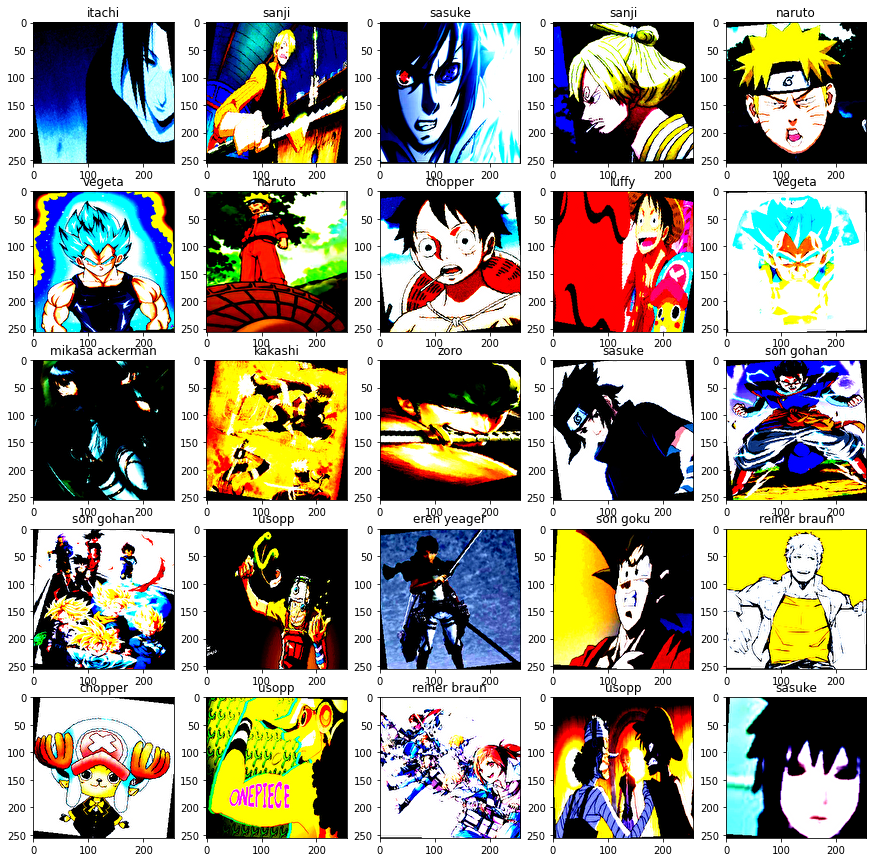

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [ ]:
# Plot some training data
fig, axs = plt.subplots(5, 5, figsize=(15,15))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for image_list in (dataloader['TRAIN']):
            np_image=image_list[0][0]
            label_tensor=image_list[1][0]

            max_index = (label_tensor.item())
            label = classes[max_index]

            x=np_image.squeeze()
            x = np.transpose(x, (1,2,0))
            axs[j,i].imshow(x, interpolation='sinc', cmap='gray');
            axs[j,i].title.set_text(label);
            break
plt.show()

## Training process begins

In [23]:
#@title Epoch function

def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train(True)
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
  model.train(False)

  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy
      
  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [24]:
EPOCH =  15#@param {type:"integer"}

In [25]:
#@title Resnet50
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [26]:
NAME = f"ResNet50trial"
LR = 0.001

# model.load_state_dict(torch.load(f"/content/{FOLDERS['MODELS']}/{NAME}.pth"))

ResNet50trial INITIALIZED
Epoch: 1/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 2.339 Test Accuracy: 0.379
Train Loss: 2.163 Train Accuracy: 0.335
Time: 15.93 min(s)
Epoch: 2/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.620 Test Accuracy: 0.526
Train Loss: 1.559 Train Accuracy: 0.511
Time: 31.95 min(s)
Epoch: 3/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.403 Test Accuracy: 0.590
Train Loss: 1.274 Train Accuracy: 0.601
Time: 48.02 min(s)
Improvement detected. Saving the model

Epoch: 4/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.418 Test Accuracy: 0.594
Train Loss: 1.102 Train Accuracy: 0.655
Time: 64.06 min(s)
Epoch: 5/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.163 Test Accuracy: 0.642
Train Loss: 0.996 Train Accuracy: 0.694
Time: 79.85 min(s)
Improvement detected. Saving the model

Epoch: 6/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.087 Test Accuracy: 0.670
Train Loss: 0.897 Train Accuracy: 0.720
Time: 95.75 min(s)
Improvement detected. Saving the model

Epoch: 7/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.195 Test Accuracy: 0.663
Train Loss: 0.816 Train Accuracy: 0.747
Time: 111.39 min(s)
Epoch: 8/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.181 Test Accuracy: 0.655
Train Loss: 0.748 Train Accuracy: 0.768
Time: 127.02 min(s)
Epoch: 9/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.182 Test Accuracy: 0.660
Train Loss: 0.684 Train Accuracy: 0.789
Time: 142.89 min(s)
Epoch: 10/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.235 Test Accuracy: 0.675
Train Loss: 0.647 Train Accuracy: 0.794
Time: 158.78 min(s)
Epoch: 11/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.150 Test Accuracy: 0.685
Train Loss: 0.594 Train Accuracy: 0.815
Time: 174.75 min(s)
Epoch: 12/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.099 Test Accuracy: 0.709
Train Loss: 0.535 Train Accuracy: 0.830
Time: 190.80 min(s)
Epoch: 13/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.150 Test Accuracy: 0.716
Train Loss: 0.503 Train Accuracy: 0.841
Time: 206.57 min(s)
Epoch: 14/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.086 Test Accuracy: 0.718
Train Loss: 0.479 Train Accuracy: 0.847
Time: 222.52 min(s)
Improvement detected. Saving the model

Epoch: 15/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/502 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/126 [00:00<?, ?it/s]

Test Loss: 1.201 Test Accuracy: 0.713
Train Loss: 0.419 Train Accuracy: 0.867
Time: 238.29 min(s)
Total time taken to train for 15 epochs on ResNet50trial: 238.29 min(s)
86.73% highest train accuracy at 14 epoch  and 71.78% highest test accuracy at 13 epoch


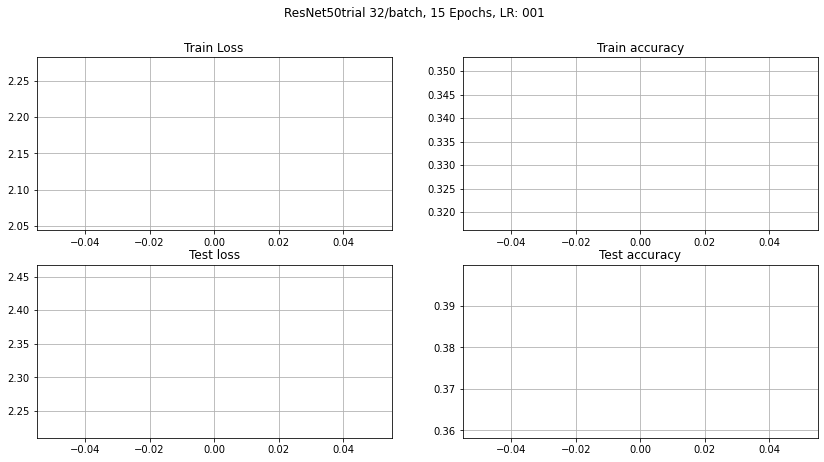

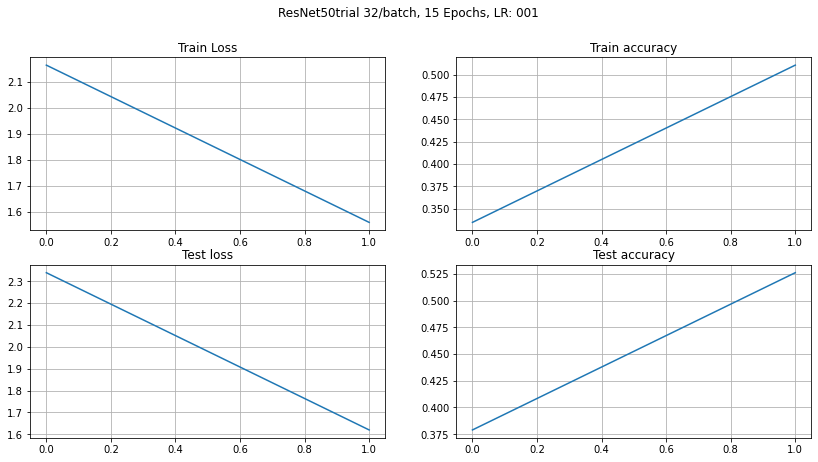

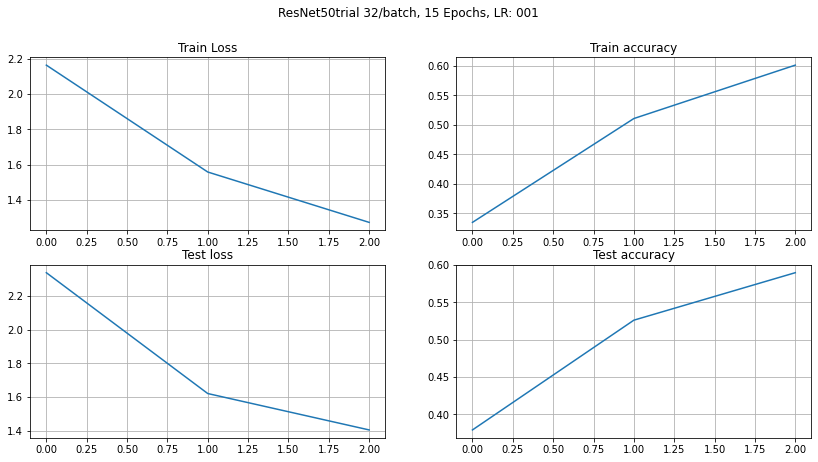

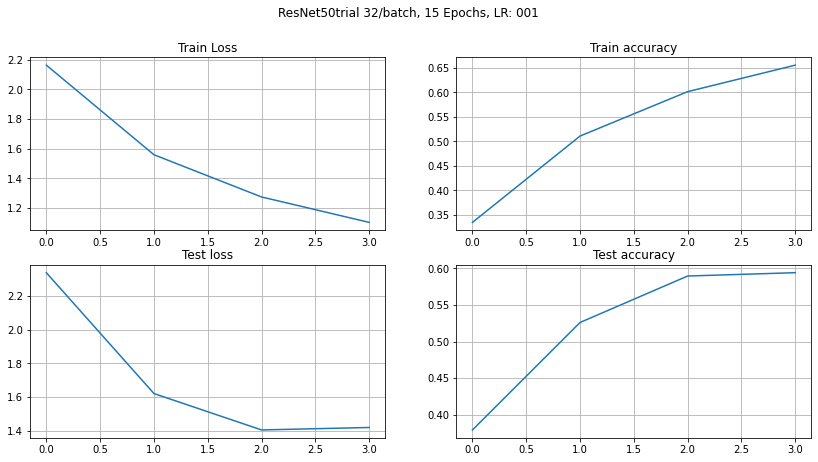

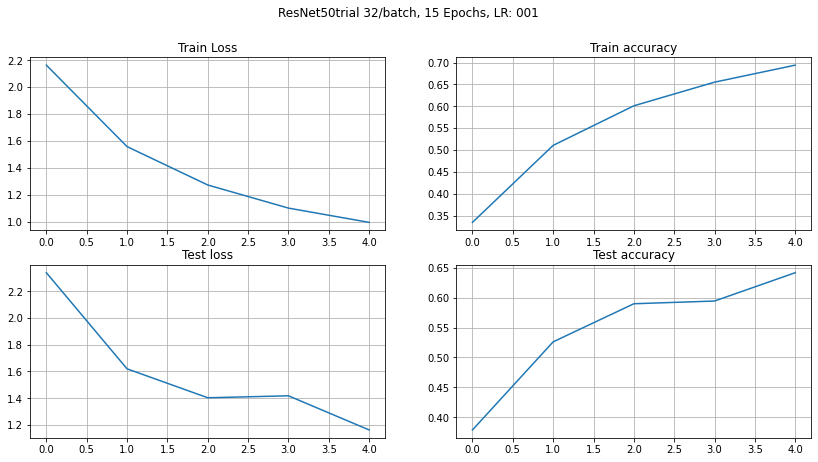

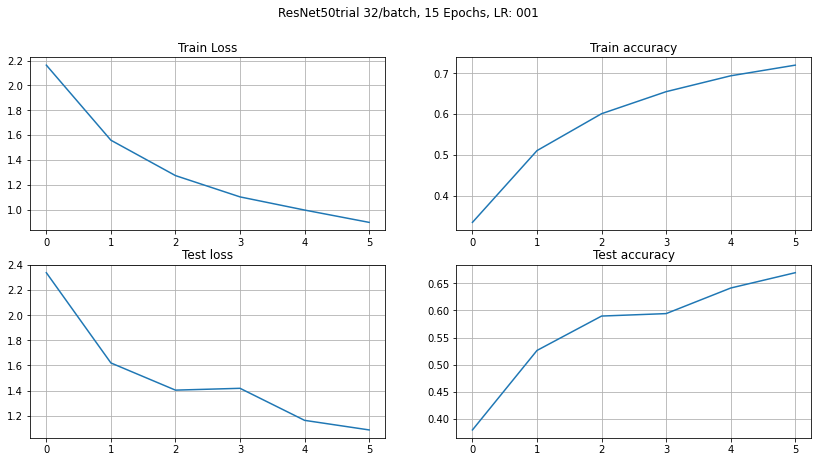

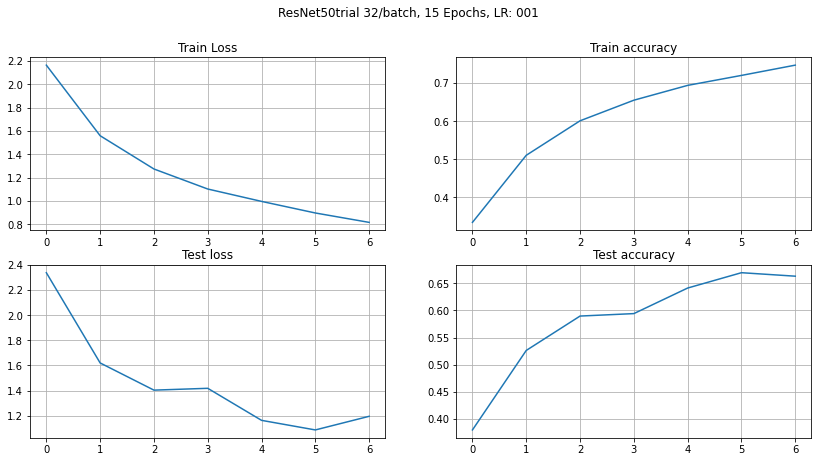

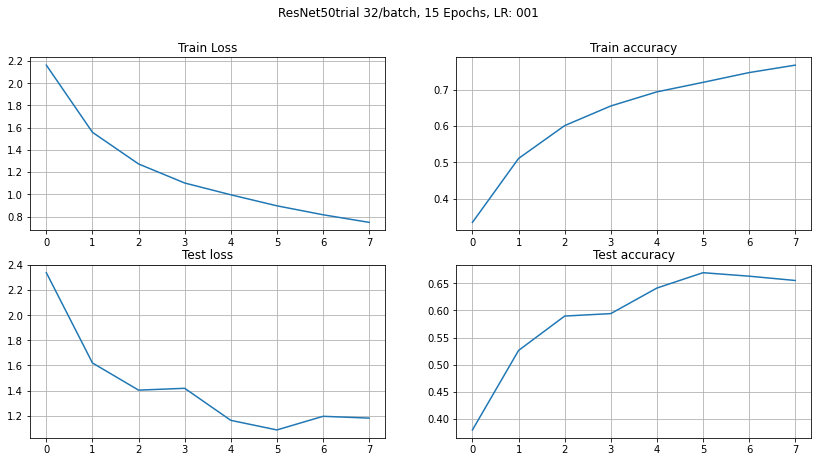

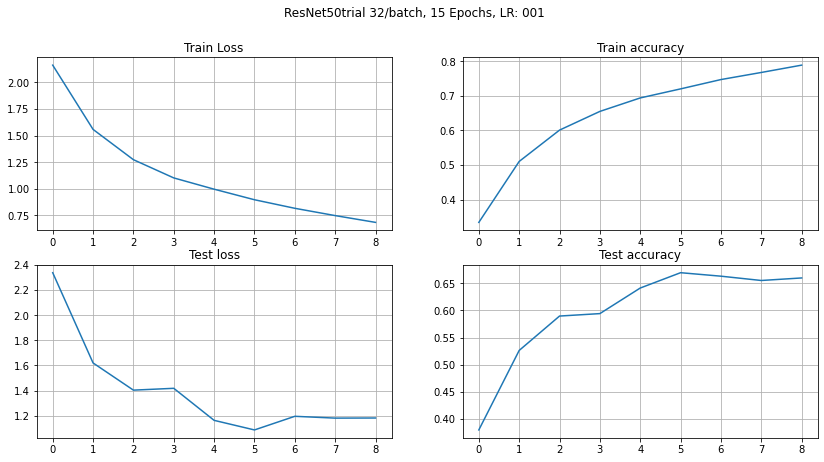

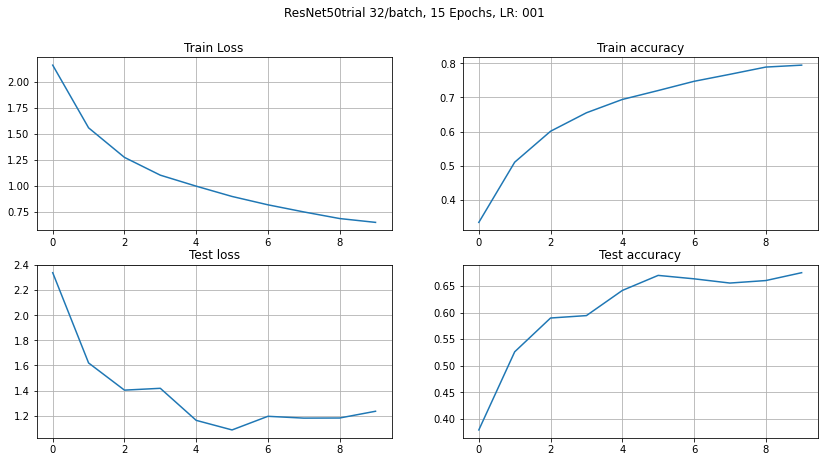

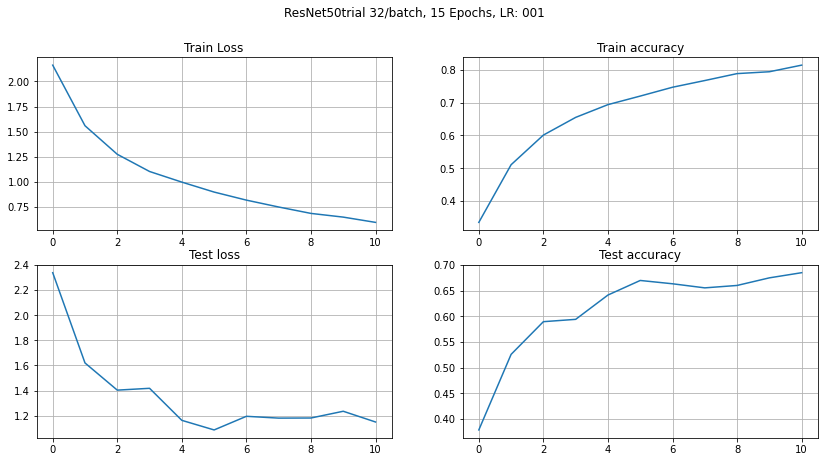

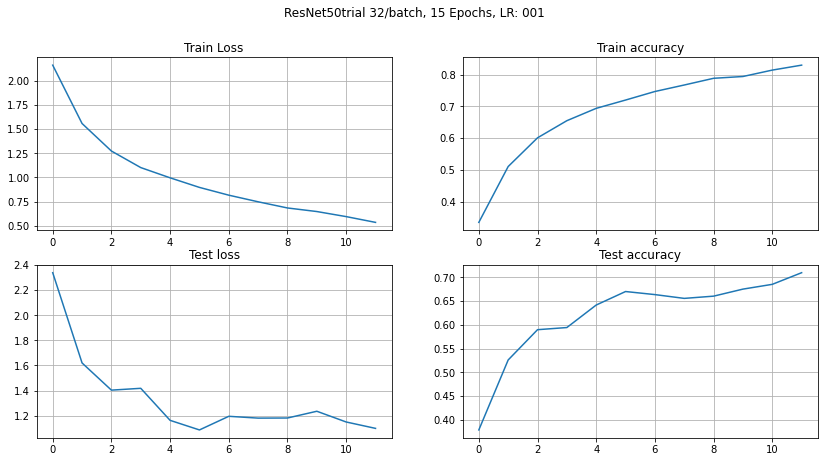

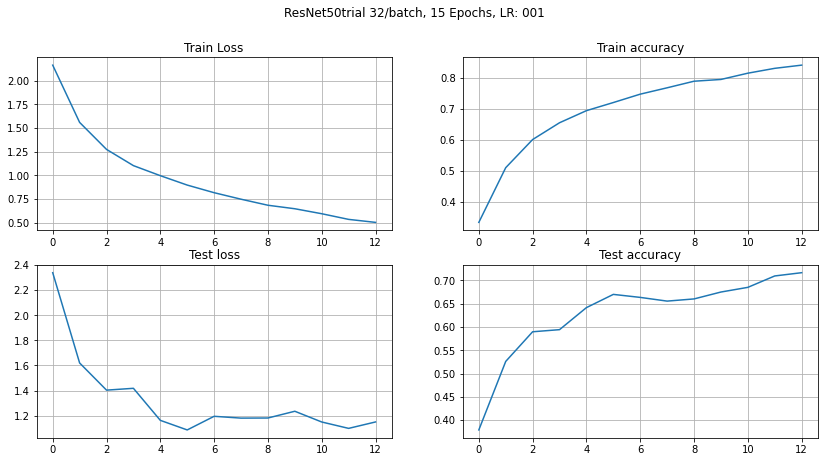

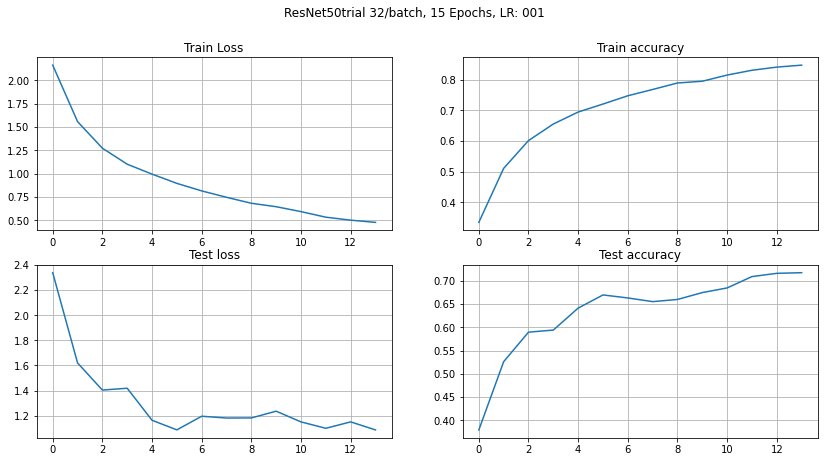

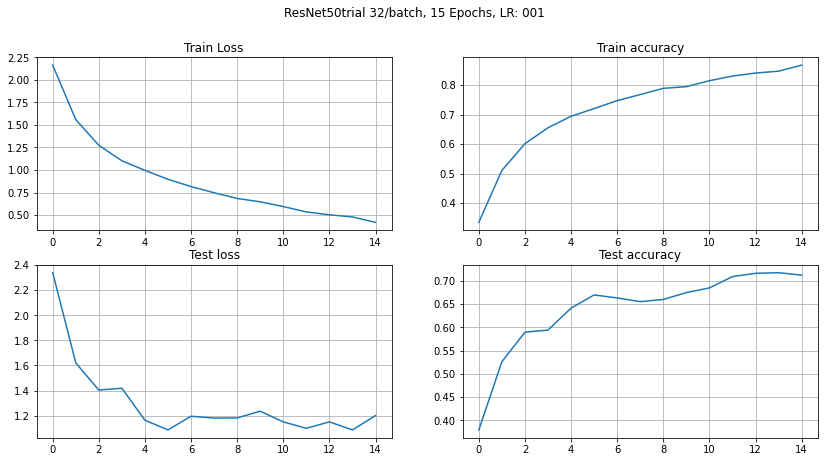

In [28]:
done = False

model = model.to(device)

print(f"{NAME} INITIALIZED")


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")

  vals = epoch(model, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Test Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}")
  print(f"Train Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}")
  
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")

      torch.save(model.state_dict(),model_name)

  fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
  a[0][0].plot(train_loss_vals)
  a[0][0].set_title("Train Loss")
  a[0][0].grid(True)
  a[0][1].plot(train_accuracy_vals)
  a[0][1].set_title("Train accuracy")
  a[0][1].grid(True)
  a[1][0].plot(test_loss_vals)
  a[1][0].set_title("Test loss")
  a[1][0].grid(True)
  a[1][1].plot(test_accuracy_vals)
  a[1][1].set_title("Test accuracy")
  a[1][1].grid(True)
  fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
  
  if ep>2:
    performanceplot = f"PERFORMANCE.jpg"
    fig.savefig(performanceplot)

print(f"Total time taken to train for {EPOCH} epochs on {NAME}: {(time.time()-start)/60:.2f} min(s)")

print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch ",
      f"and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")

done = True

## Plot some predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

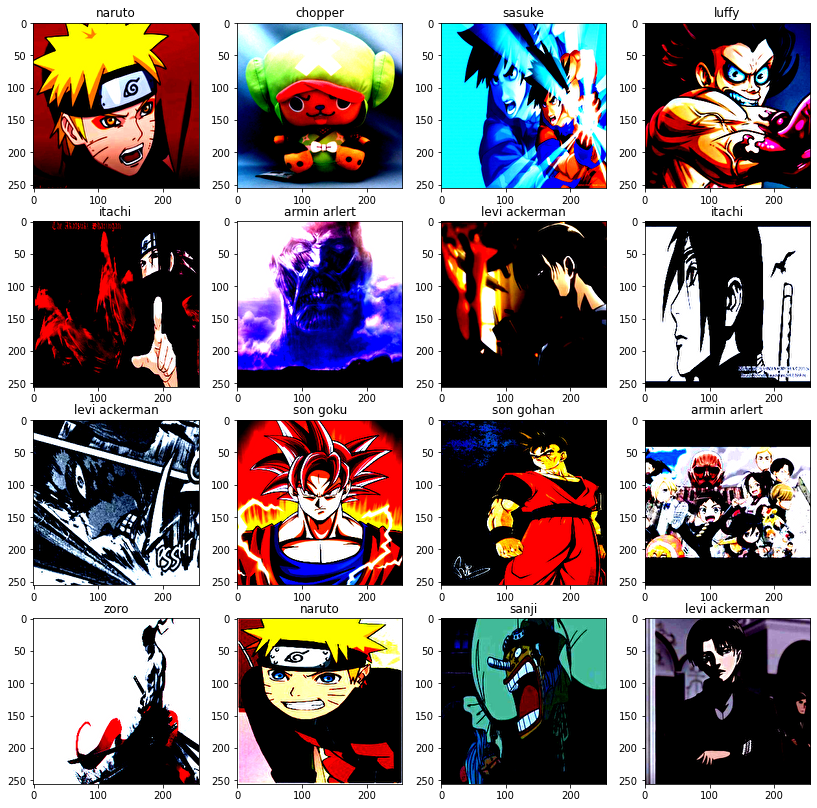

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(14,14))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for image_list in (dataloader["TEST"]):

            p_image=image_list[0][0]
            x=p_image.squeeze()

            x = x.swapaxes(0,1)
            x = x.swapaxes(1,2)
            axs[j,i].imshow(x, interpolation='sinc', cmap='gray')

            with torch.no_grad():

              model.eval()
              p_image=p_image.cuda()
              lab=model(p_image.unsqueeze(0))
              lab=lab.cpu()
              max_index = np.argmax(lab[0]) 
              predicted_emotion = classes[max_index]
            
            axs[j,i].title.set_text(predicted_emotion)
            break

plt.show()

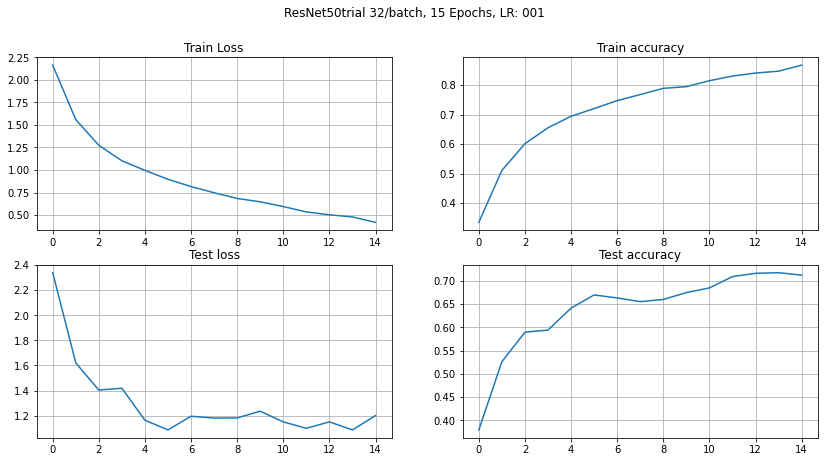

In [30]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)

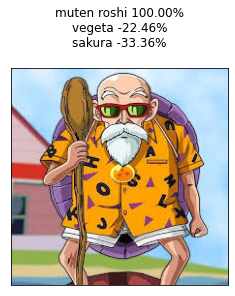

In [55]:
import requests
img_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6W0TmmuMAvUiPuSs82HG6q-BZltC7qfNItQ&usqp=CAU" #@param {type:"string"}
img = Image.open(requests.get(img_url, stream=True).raw)
img_processed = transformations['TEST'](img)


preds = model(img_processed.unsqueeze(0).to(device))
preds = preds.cpu().data.numpy()
f = plt.imshow(img)
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
pred = ''
idx = np.argsort(preds[0])
idx = idx.tolist()

if type(preds) != list:
  preds = preds.tolist()
for i in idx[::-1][:3]:
  pred+= f"{classes[i]} {(preds[0][i]/preds[0][idx[-1]])*100:.2f}%\n"
plt.title(
    pred,
    loc='center'
);

In [37]:
classes

['armin arlert',
 'chopper',
 'eren yeager',
 'frieza',
 'itachi',
 'kakashi',
 'levi ackerman',
 'luffy',
 'mikasa ackerman',
 'muten roshi',
 'naruto',
 'reiner braun',
 'sakura',
 'sanji',
 'sasuke',
 'son gohan',
 'son goku',
 'usopp',
 'vegeta',
 'zoro']